In [1]:
import sys,os
from os.path import expanduser as eu,exists
from concurrent.futures import ProcessPoolExecutor as Pool

import numpy as np,pandas as pd
import networkx as nx
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.edgecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.edgecolor']='white'
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42

def pltcolor(n):
    return plt.rcParams['axes.prop_cycle'].by_key()['color'][n]
def cdf(data):
    y=np.linspace(0,1,100)
    x=np.percentile(data,y*100)
    return x,y

In [2]:
generation_step=100
operators=['MNO1','MNO2','MNO3']
hows=['location+all','demand+all','location+video','demand+video','location+gaming','demand+gaming']
metrics=set([h.split('+')[0] for h in hows])
def sani(op):
    return filter(str.isalnum,op.lower())

In [3]:
datas={}
def get_data(operator,how,ticks):
    if not (operator,how,ticks) in datas:
        soperator=sani(operator)
        ticks_word=('ticks' if ticks else 'noticks')
        datas[(operator,how,ticks)]=pd.read_csv('reports/xreport_%s_%s_%s.csv.bz2'%(soperator,how,ticks_word),compression='bz2')
    return datas[(operator,how,ticks)]

In [4]:
def compose_data(operator,metric,ticks,per_class):
    if per_class:
        data1=get_data(operator,metric+'+gaming',ticks).sort_values('iteration').reset_index(drop=True)
        data2=get_data(operator,metric+'+video',ticks).sort_values('iteration').reset_index(drop=True)
        only_in_1=set(data1['iteration'].unique())-set(data2['iteration'].unique())
        only_in_2=set(data2['iteration'].unique())-set(data1['iteration'].unique())
        extra1=data1.head(0)
        extra2=data2.head(0)
        for i in only_in_1:
            time_to_duplicate=data2.query('iteration<%d'%(i,))['iteration'].max()
            rows_to_duplicate=data2.query('iteration==%d'%(time_to_duplicate,)).copy()
            rows_to_duplicate['iteration']=i
            extra2=extra2.append(rows_to_duplicate)
        for i in only_in_2:
            time_to_duplicate=data1.query('iteration<%d'%(i,))['iteration'].max()
            rows_to_duplicate=data1.query('iteration==%d'%(time_to_duplicate,)).copy()
            rows_to_duplicate['iteration']=i
            extra1=extra1.append(rows_to_duplicate)
        data=pd.concat([data1,data2,extra1,extra2])
    else:
        data=get_data(operator,metric+'+all',ticks)
    return data

In [5]:
def get_server_stats(data,keep_category=False):
    server_stats=(
        data
        .groupby(['iteration','server','server_type','macro_category'],as_index=False)
        .agg({'server_peak_ticks':'max','server_tot_ticks':'max','server_peak_traffic':'max','server_tot_traffic':'max','servee':'nunique'})
    )
    if not keep_category: #double group-by, needed to get rid of the macro_category column
        server_stats=(
            server_stats
            .groupby(['iteration','server','server_type'],as_index=False)
            .agg({'server_peak_ticks':'sum','server_tot_ticks':'sum','server_peak_traffic':'sum','server_tot_traffic':'sum','servee':'sum'})
        )
    return server_stats

In [6]:
def draw_filled(operator,metric,ticks,per_class):
    data=compose_data(operator,metric,ticks,per_class)
    server_stats=get_server_stats(data)
    served_where=(
        server_stats
        .groupby(['iteration','server_type'],as_index=False)
        .agg({'server_tot_traffic':'sum','server_tot_ticks':'sum','server':'nunique'})
    )
    
    ylabels={'server_tot_ticks':'CPU capacity [Gticks]','server_tot_traffic':'Traffic [GByte]','server':'Number of servers'}
    coeff={'server_tot_ticks':1e9,'server_tot_traffic':1e9,'server':1}
    plot_name={'server_tot_ticks':'ticks','server_tot_traffic':'mbit','server':'nsrv'}
    for plot_type in ylabels.keys():
        fig=plt.figure(figsize=plt.figaspect(.85))
        ax=fig.add_subplot(111)
        my_data=served_where.pivot_table(values=plot_type,index='iteration',columns='server_type').reset_index().fillna(0)
        y0=0
        x=my_data['iteration']
        ax.fill_between(x,y0,y0+my_data['cel']/coeff[plot_type],color=pltcolor(0),label='cell')
        y0=my_data['cel']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data['rin']/coeff[plot_type],color=pltcolor(1),label='ring')
        y0+=my_data['rin']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data['agg']/coeff[plot_type],color=pltcolor(2),label='aggr.')
        y0+=my_data['agg']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data['cor']/coeff[plot_type],color=pltcolor(3),label='core')
        ax.set_ylabel(ylabels[plot_type])
        ax.set_xlabel('Iteration')
        ax.legend(loc=('lower left' if metric=='location' else 'upper right'))
        ax.set_xlim(0,None)
        ax.set_ylim(0,None)
        fig.savefig('img/fill%s_%s_%s_%s_%s.eps'%(plot_name[plot_type],sani(operator),metric,('ticks' if ticks else 'mbit'),('delay' if per_class else 'nodelay')),bbox_inches='tight')
        ax.set_title('%s/%s/%s/%s'%(operator,metric,('Ticks' if ticks else 'MBit'),('delay' if per_class else 'no delay')))

In [7]:
def compute_eff(operator,metric,ticks,per_class,split=False):
    data=compose_data(operator,metric,ticks,per_class)
    server_stats=get_server_stats(data)
    iter_stats=(
        server_stats.groupby(['iteration']+(['server_type'] if split else []),as_index=False)
        .agg({'server_tot_traffic':'sum','server_peak_traffic':'sum','server_tot_ticks':'sum','server_peak_ticks':'sum','server':'nunique'})
    )
    iter_stats['eff']=iter_stats['server_tot_ticks']/24.0/iter_stats['server_peak_ticks']
    return iter_stats[['iteration','eff','server']+(['server_type'] if split else [])]

In [8]:
def draw_efficiency(operator,per_class):
    fig,ax=plt.subplots()
    eff_dem_m=compute_eff(operator,'demand',0,per_class)
    eff_dem_t=compute_eff(operator,'demand',1,per_class)
    eff_loc_m=compute_eff(operator,'location',0,per_class)
    eff_loc_t=compute_eff(operator,'location',1,per_class)
    ax.plot(eff_loc_m['iteration'],eff_loc_m['eff'],color=pltcolor(0),linestyle='-',label='')
    ax.plot(eff_loc_t['iteration'],eff_loc_t['eff'],color=pltcolor(0),linestyle='--',label='')
    ax.plot(eff_dem_m['iteration'],eff_dem_m['eff'],color=pltcolor(1),linestyle='-',label='')
    ax.plot(eff_dem_t['iteration'],eff_dem_t['eff'],color=pltcolor(1),linestyle='--',label='')
    ax.scatter([],[],color=pltcolor(0),s=200,marker='s',label='Loc.-based')
    ax.scatter([],[],color=pltcolor(1),s=200,marker='s',label='Load-based')
    ax.plot([],[],color='black',linestyle='-',label='Original')
    ax.plot([],[],color='black',linestyle='--',label='Enriched')
    ax.set_ylabel('Efficiency')
    ax.set_xlabel('Iteration')
    ax.legend(ncol=2)
    ax.set_xlim(0,None)
    ax.set_ylim(0,0.5)
    fig.savefig('img/efficiency_%s_%s.eps'%(sani(operator),('delay' if per_class else 'nodelay')),bbox_inches='tight')
    ax.set_title('%s/%s/%s/%s'%(operator,'*','*',('delay' if per_class else 'no delay')))

In [9]:
def compute_delay(operator,metric,ticks,per_class):
    data=compose_data(operator,metric,ticks,per_class).copy()
    data['delay']=5+7.0*(data['distance_hops']-1)/3
    data['delay_times_traffic']=data['delay']*data['cell_tot_traffic']
    iter_delays=data.groupby(['iteration'],as_index=False).agg({'delay_times_traffic':'sum','cell_tot_traffic':'sum'})
    iter_delays['avg_delay']=iter_delays['delay_times_traffic']/iter_delays['cell_tot_traffic']
    return iter_delays

In [10]:
def draw_delay(operator,per_class):
    fig,ax=plt.subplots()
    delay_dem_m=compute_delay(operator,'demand',0,per_class)[:-1]
    delay_dem_t=compute_delay(operator,'demand',1,per_class)[:-1]
    delay_loc_m=compute_delay(operator,'location',0,per_class)[:-1]
    delay_loc_t=compute_delay(operator,'location',1,per_class)[:-1]
    ax.plot(delay_loc_m['iteration'],delay_loc_m['avg_delay'],color=pltcolor(0),linestyle='-',label='')
    ax.plot(delay_loc_t['iteration'],delay_loc_t['avg_delay'],color=pltcolor(0),linestyle='--',label='')
    ax.plot(delay_dem_m['iteration'],delay_dem_m['avg_delay'],color=pltcolor(1),linestyle='-',label='')
    ax.plot(delay_dem_t['iteration'],delay_dem_t['avg_delay'],color=pltcolor(1),linestyle='--',label='')
    ax.scatter([],[],color=pltcolor(0),s=200,marker='s',label='Loc.-based')
    ax.scatter([],[],color=pltcolor(1),s=200,marker='s',label='Load-based')
    ax.plot([],[],color='black',linestyle='-',label='Original')
    ax.plot([],[],color='black',linestyle='--',label='Enriched')
    ax.set_ylabel('Average delay [ms]')
    ax.set_xlabel('Iteration')
    ax.legend(ncol=2)
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    fig.savefig('img/delay_%s_%s.eps'%(sani(operator),('delay' if per_class else 'nodelay')),bbox_inches='tight')
    ax.set_title('%s/%s/%s/%s'%(operator,'*','*',('delay' if per_class else 'no delay')))

In [11]:
def draw_delay_eff_scatter(operator,per_class):
    fig,ax=plt.subplots()
    data_dem_m=compute_delay(operator,'demand',0,per_class).merge(compute_eff(operator,'demand',0,per_class),how='inner')
    data_dem_t=compute_delay(operator,'demand',1,per_class).merge(compute_eff(operator,'demand',1,per_class),how='inner')
    data_loc_m=compute_delay(operator,'location',0,per_class).merge(compute_eff(operator,'location',0,per_class),how='inner')
    data_loc_t=compute_delay(operator,'location',1,per_class).merge(compute_eff(operator,'location',1,per_class),how='inner')
    ax.scatter(data_loc_m['avg_delay'],data_loc_m['eff'],color=pltcolor(0),marker='o',label='Loc.-based/original',s=200,facecolors='none',lw=2)
    ax.scatter(data_loc_t['avg_delay'],data_loc_t['eff'],color=pltcolor(0),marker='x',label='Loc.-based/enriched',s=200,lw=2)
    ax.scatter(data_dem_m['avg_delay'],data_dem_m['eff'],color=pltcolor(1),marker='s',label='Load-based/original',s=200,facecolors='none',lw=2)
    ax.scatter(data_dem_t['avg_delay'],data_dem_t['eff'],color=pltcolor(1),marker='+',label='Load-based/enriched',s=200,lw=2)
    ax.set_xlabel('Average delay [ms]')
    ax.set_ylabel('Efficiency')
    ax.legend()
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    fig.savefig('img/delayeffscatter_%s_%s.eps'%(sani(operator),('delay' if per_class else 'nodelay')),bbox_inches='tight')
    ax.set_title('%s/%s/%s/%s'%(operator,'*','*',('delay' if per_class else 'no delay')))

In [12]:
def compute_delay_aware(operator,metric,ticks):
    data=get_data(operator,metric+'+gaming',ticks)
    data['delay']=5+7.0*(data['distance_hops']-1)/3
    data['delay_times_traffic']=data['delay']*data['cell_tot_traffic']
    iter_delays=data.groupby(['iteration'],as_index=False).agg({'delay_times_traffic':'sum','cell_tot_traffic':'sum'})
    iter_delays['avg_delay']=iter_delays['delay_times_traffic']/iter_delays['cell_tot_traffic']
    id1=iter_delays.copy()
    id1['macro_category']='gaming'
    data=get_data(operator,metric+'+video',ticks)
    data['delay']=5+7.0*(data['distance_hops']-1)/3
    data['delay_times_traffic']=data['delay']*data['cell_tot_traffic']
    iter_delays=data.groupby(['iteration'],as_index=False).agg({'delay_times_traffic':'sum','cell_tot_traffic':'sum'})
    iter_delays['avg_delay']=iter_delays['delay_times_traffic']/iter_delays['cell_tot_traffic']
    id2=iter_delays.copy()
    id2['macro_category']='video'
    return pd.concat([id1,id2])

In [13]:
def draw_delay_aware(operator,metric):
    fig,ax=plt.subplots()
    stats_m=compute_delay_aware(operator,metric,0)
    stats_t=compute_delay_aware(operator,metric,1)
    for i,cat in enumerate(['gaming','video']):
        my_lines=stats_m[stats_m['macro_category']==cat]
        ax.plot(my_lines['iteration'],my_lines['avg_delay'],color=pltcolor(4+i),linestyle='-',label='')
        my_lines=stats_t[stats_t['macro_category']==cat]
        ax.plot(my_lines['iteration'],my_lines['avg_delay'],color=pltcolor(4+i),linestyle='--',label='')
        ax.scatter([],[],color=pltcolor(4+i),s=200,marker='s',label=cat)
    ax.plot([],[],color='black',linestyle='-',label='Original')
    ax.plot([],[],color='black',linestyle='--',label='Enriched')
    ax.set_ylabel('Average delay [ms]')
    ax.set_xlabel('Iteration')
    ax.legend(ncol=2)
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    fig.savefig('img/delayaware_%s_%s.eps'%(sani(operator),metric),bbox_inches='tight')
    ax.set_title('%s/%s/%s/%s'%(operator,metric,'*','delay'))

In [14]:
def draw_filled_withcategories(operator,metric,ticks,per_class):
    data=compose_data(operator,metric,ticks,per_class)
    server_stats=get_server_stats(data,keep_category=True)
    served_where=(
        server_stats
        .groupby(['iteration','server_type','macro_category'],as_index=False)
        .agg({'server_tot_traffic':'sum','server_tot_ticks':'sum','server':'nunique'})
    )
    all_iter=served_where['iteration'].unique()
    all_types=served_where['server_type'].unique()
    all_cats=served_where['macro_category'].unique()
    all_triples=pd.DataFrame(list(product(all_iter,all_types,all_cats)),columns=['iteration','server_type','macro_category'])
    served_where=all_triples.merge(served_where,how='left').fillna(0)
    
    ylabels={'server_tot_ticks':'CPU capacity [Gticks]','server_tot_traffic':'Traffic [GByte]'}
    coeff={'server_tot_ticks':1e9,'server_tot_traffic':1e9,'server':1}
    plot_name={'server_tot_ticks':'ticks','server_tot_traffic':'mbit','server':'nsrv'}
    for plot_type in ylabels.keys():
        fig=plt.figure() #(figsize=plt.figaspect(.85))
        ax=fig.add_subplot(111)
        my_data_v=served_where.query('macro_category=="video"').pivot_table(values=plot_type,index='iteration',columns='server_type').reset_index().fillna(0)
        my_data_g=served_where.query('macro_category=="gaming"').pivot_table(values=plot_type,index='iteration',columns='server_type').reset_index().fillna(0)
        y0=0
        x=my_data_v['iteration']
        ax.fill_between(x,y0,y0+my_data_g['cel']/coeff[plot_type],edgecolor=pltcolor(0),label='',hatch='XXXX',facecolor='white')
        y0+=my_data_g['cel']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data_v['cel']/coeff[plot_type],color=pltcolor(0),label='')
        y0+=my_data_v['cel']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data_g['rin']/coeff[plot_type],edgecolor=pltcolor(1),label='',hatch='XXXX',facecolor='white')
        y0+=my_data_g['rin']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data_v['rin']/coeff[plot_type],color=pltcolor(1),label='')
        y0+=my_data_v['rin']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data_g['agg']/coeff[plot_type],edgecolor=pltcolor(2),label='',hatch='XXXX',facecolor='white')
        y0+=my_data_g['agg']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data_v['agg']/coeff[plot_type],color=pltcolor(2),label='')
        y0+=my_data_v['agg']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data_g['cor']/coeff[plot_type],edgecolor=pltcolor(3),label='',hatch='XXXX',facecolor='white')
        y0+=my_data_g['cor']/coeff[plot_type]
        ax.fill_between(x,y0,y0+my_data_v['cor']/coeff[plot_type],color=pltcolor(3),label='')
        y0+=my_data_v['cor']/coeff[plot_type]
        ax.scatter([],[],marker='s',s=200,color=pltcolor(0),label='cell')
        ax.scatter([],[],marker='s',s=200,color=pltcolor(1),label='ring')
        ax.scatter([],[],marker='s',s=200,color=pltcolor(2),label='aggr.')
        ax.scatter([],[],marker='s',s=200,color=pltcolor(3),label='core')
        ax.fill_between([],[],[],edgecolor='black',facecolor='white',label='gaming',hatch='XXXX')
        ax.fill_between([],[],[],color='black',label='other')
        ax.set_ylabel(ylabels[plot_type])
        ax.set_xlabel('Iteration')
        ax.legend(ncol=2,loc=('center left' if metric=='location' else 'center right'))
        ax.set_xlim(0,None)
        ax.set_ylim(0,None)
        fig.savefig('img/cfill%s_%s_%s_%s_%s.eps'%(plot_name[plot_type],sani(operator),metric,('ticks' if ticks else 'mbit'),('delay' if per_class else 'nodelay')),bbox_inches='tight')
        ax.set_title('%s/%s/%s/%s'%(operator,metric,('Ticks' if ticks else 'MBit'),('delay' if per_class else 'no delay')))

# Filled plots, no delay constraint

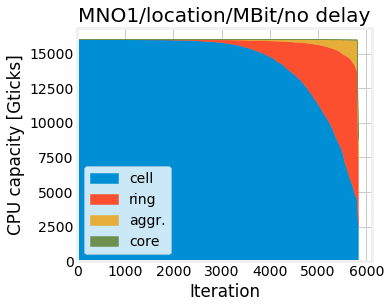

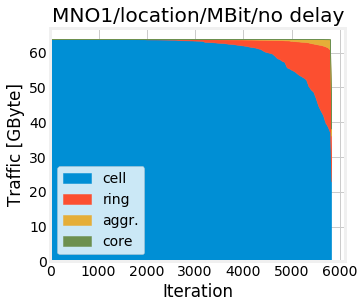

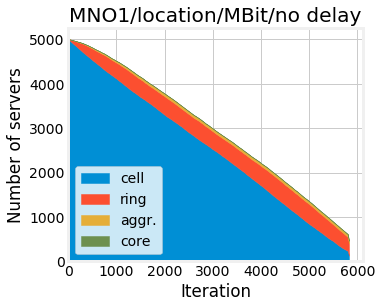

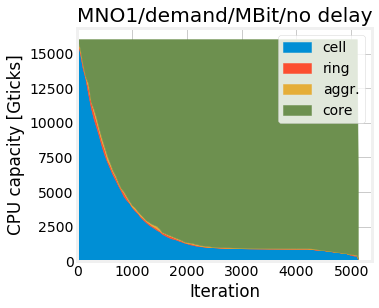

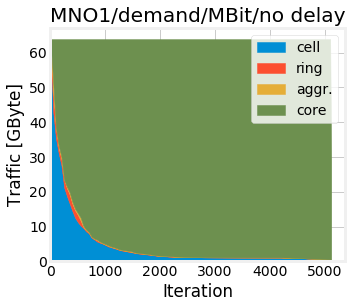

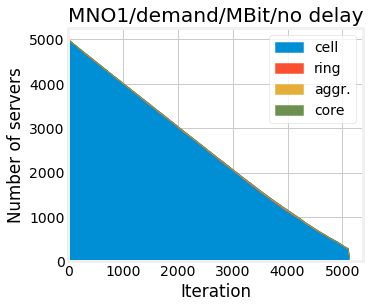

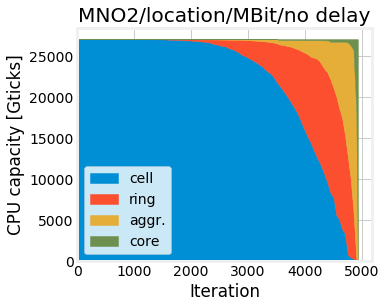

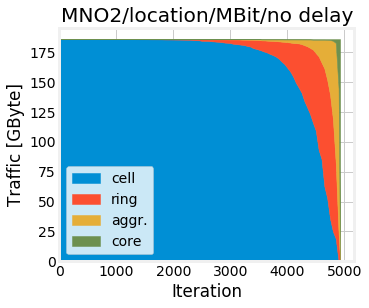

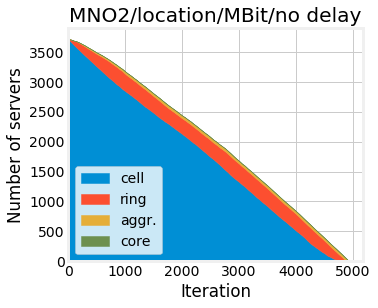

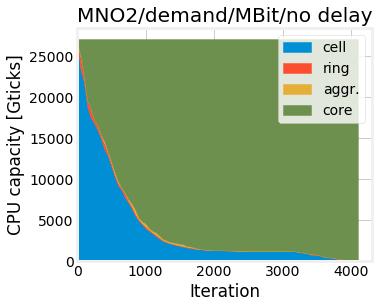

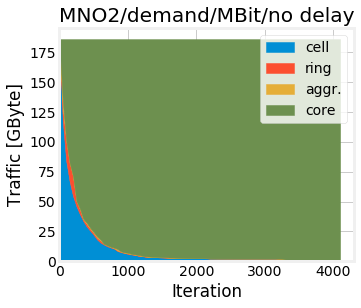

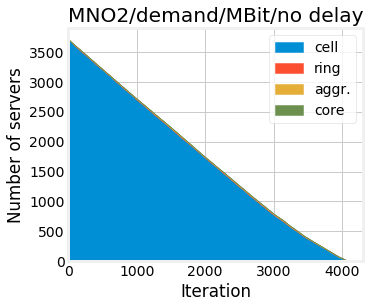

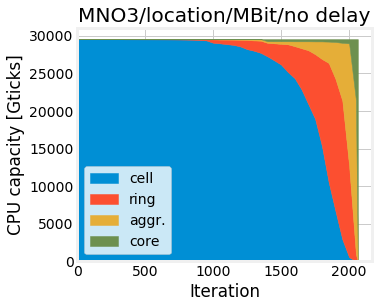

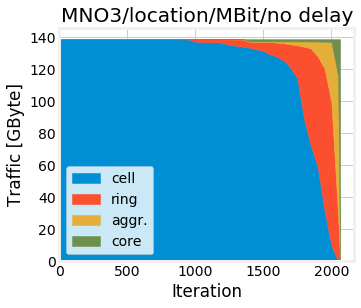

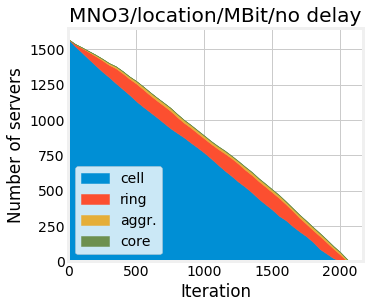

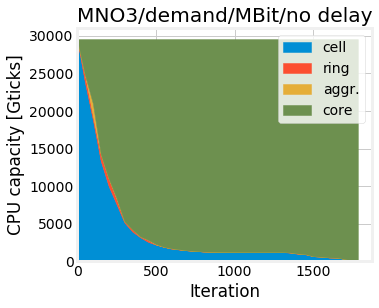

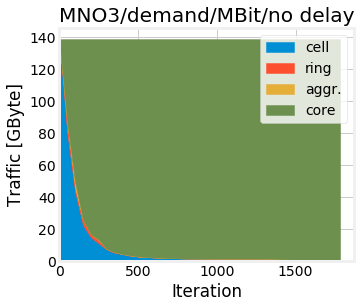

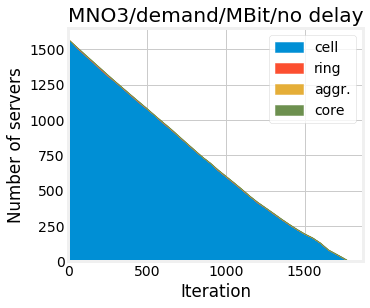

In [15]:
for op in operators:
    for m in metrics:
        draw_filled(op,m,0,0)

# Delay and efficiency, no delay constraint

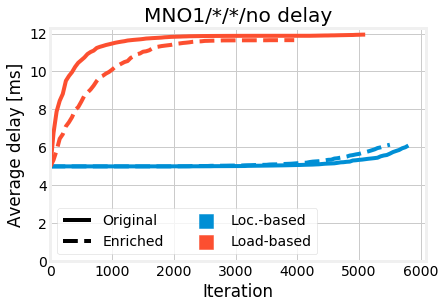

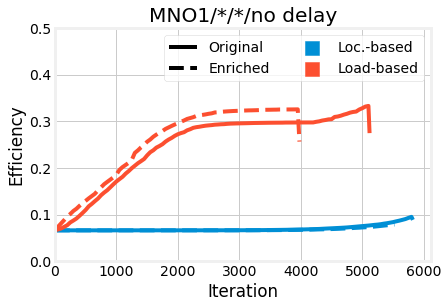

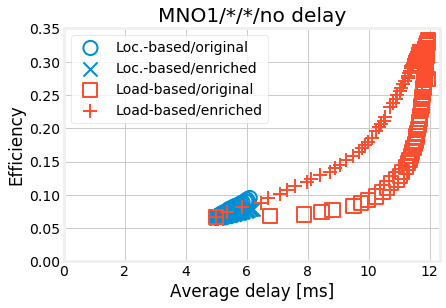

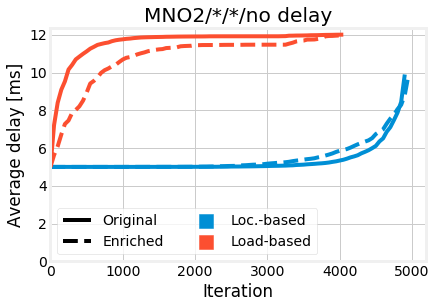

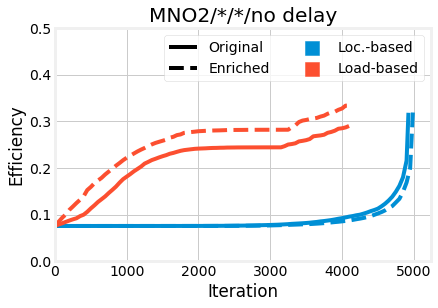

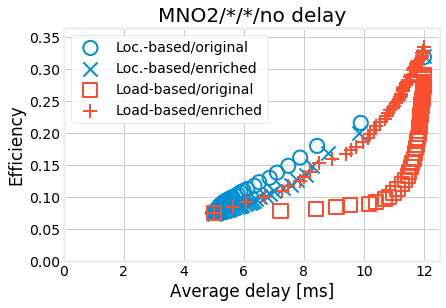

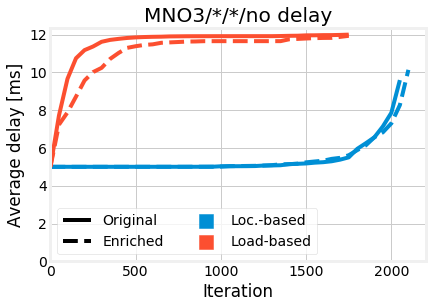

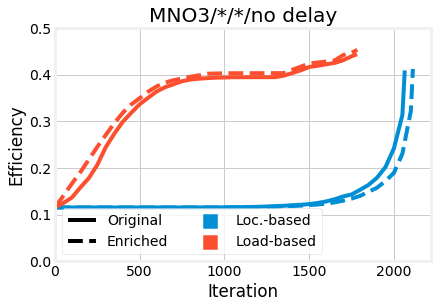

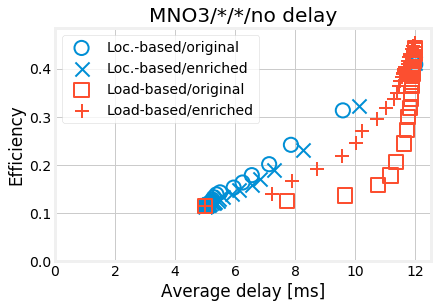

In [16]:
for op in operators:
    draw_delay(op,0)
    draw_efficiency(op,0)
    draw_delay_eff_scatter(op,0)

# Delay constraint: effect on efficiency and delay

/home/francesco/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


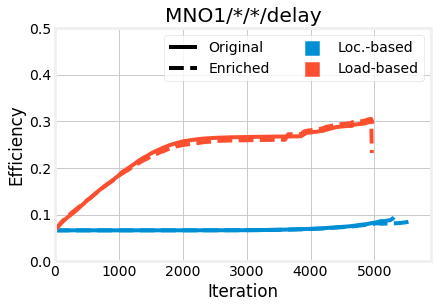

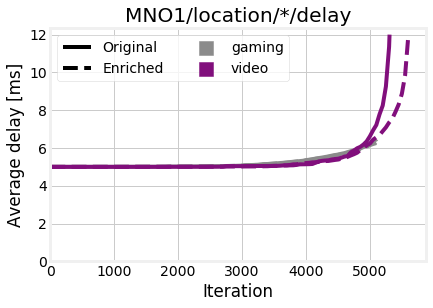

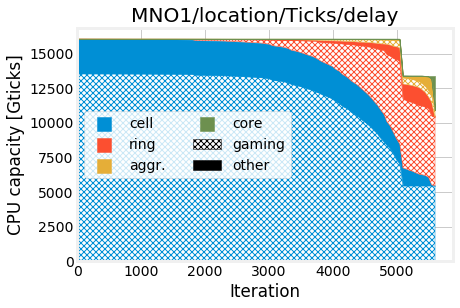

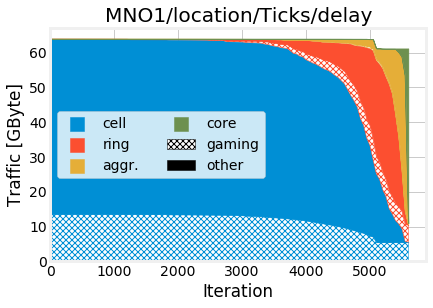

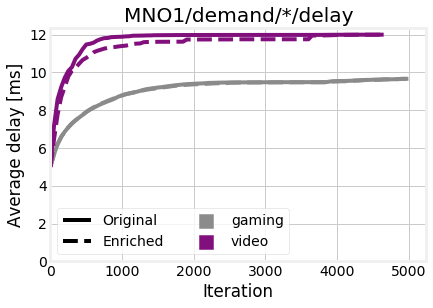

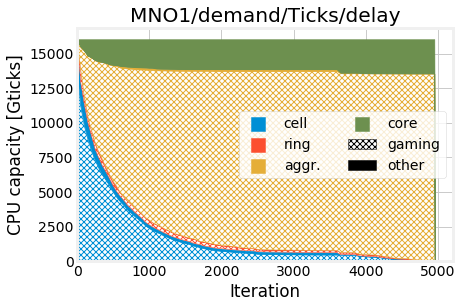

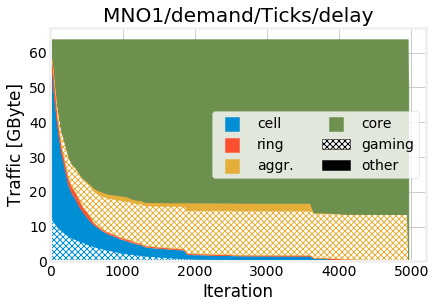

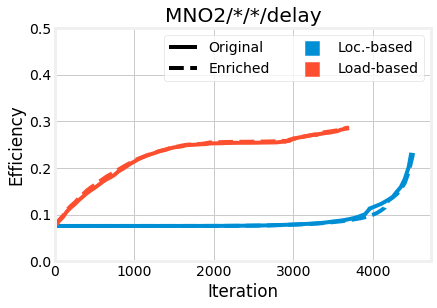

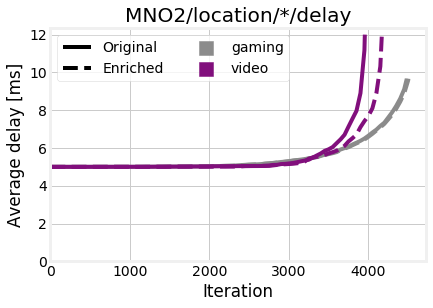

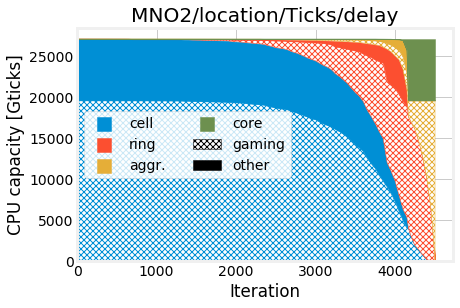

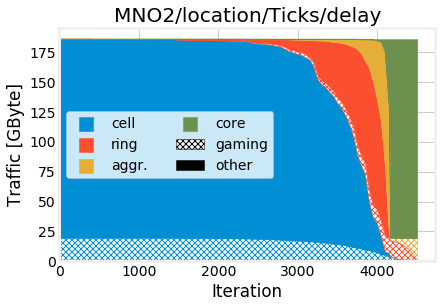

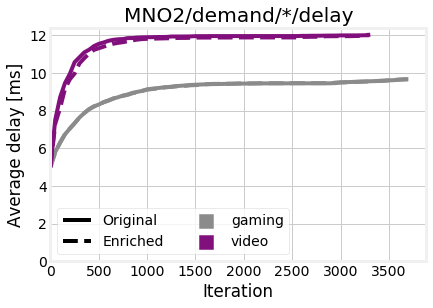

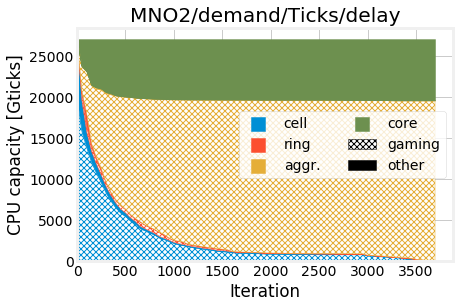

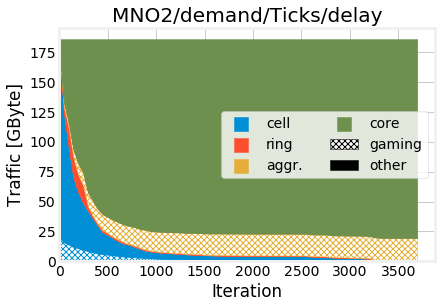

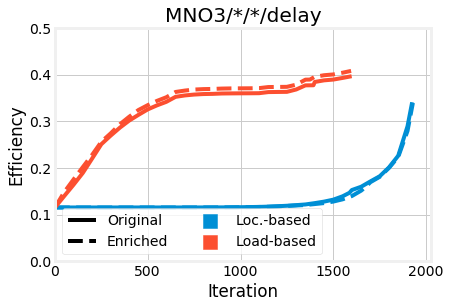

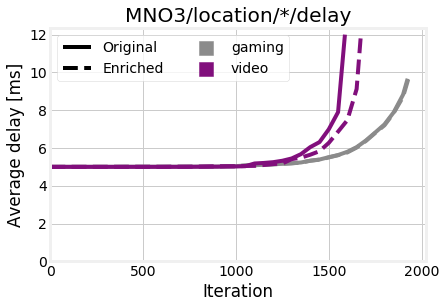

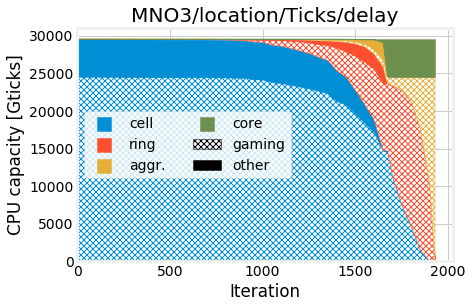

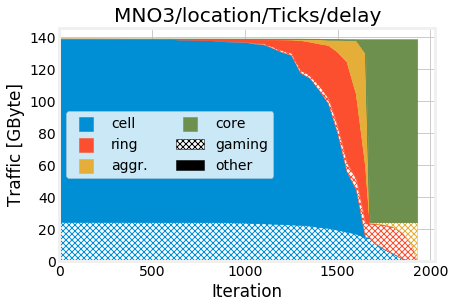

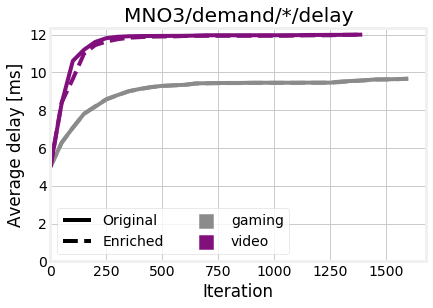

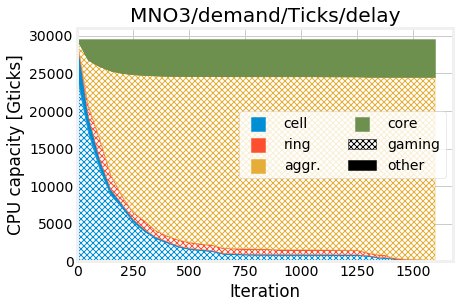

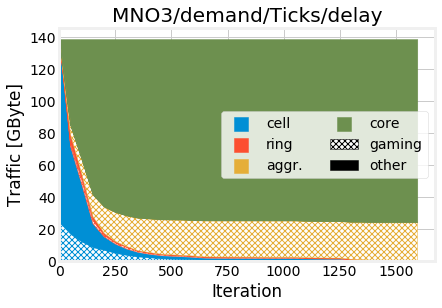

In [17]:
for op in operators:
    draw_efficiency(op,1)
    for m in metrics:
        draw_delay_aware(op,m)
        draw_filled_withcategories(op,m,1,1)